# For a single file

**Loading file and librairies**

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import tarfile
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
# Read the Parquet file
AAPL = pl.read_parquet("data/AAPL.OQ_combined.parquet")

print(AAPL.columns)
print(AAPL.head)

['index', 'xltime', 'bid-price', 'bid-volume', 'ask-price', 'ask-volume', 'trade-price', 'trade-volume', 'date']
<bound method DataFrame.head of shape: (27_695_291, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ index     ┆ xltime    ┆ bid-price ┆ bid-volum ┆ … ┆ ask-volum ┆ trade-pri ┆ trade-vol ┆ date     │
│ ---       ┆ ---       ┆ ---       ┆ e         ┆   ┆ e         ┆ ce        ┆ ume       ┆ ---      │
│ str       ┆ f64       ┆ f64       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str      │
│           ┆           ┆           ┆ i64       ┆   ┆ i64       ┆ f64       ┆ i64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-01-0 ┆ 40182.604 ┆ 213.32    ┆ 1         ┆ … ┆ 1         ┆ null      ┆ null      ┆ 2010-01- │
│ 4T09:30:0 ┆ 167       ┆           ┆           ┆   ┆           ┆           ┆           ┆ 04       │
│ 0.001000  ┆           

In [3]:
def to_timeseries(df: pl.DataFrame) -> pl.DataFrame:
    """
    Converts the existing `index` column (already a Polars datetime) into
    a standard "DATETIME" column, optionally rounding to the nearest second.
    """
    return (
        df
        .rename({"index": "DATETIME"})
        .with_columns(pl.col("DATETIME").dt.round("1s").alias("DATETIME"))
    )

## Computing the response function per day

In [4]:
def compute_response_function(df: pl.DataFrame, tau_max: int) -> np.ndarray:
    """
    Computes the response function R(tau) for all lags up to tau_max.

    Args:
        df (pl.DataFrame): DataFrame containing 'bid-price', 'ask-price', and 'trade-price'.
        tau_max (int): Maximum lag for which to compute the response function.

    Returns:
        np.ndarray: Array of response values for each tau from 1 to tau_max.
    """
    # Compute mid-price
    df = df.with_columns(
        ((pl.col("bid-price") + pl.col("ask-price")) / 2).alias("mid-price")
    )

    # Compute the sign s = sign(trade-price - mid-price), fill trade-price nulls with 0
    df = df.with_columns(
        (pl.col("trade-price").fill_null(0) - pl.col("mid-price")).sign().alias("s")
    )

    # Extract the mid-price and signal as NumPy arrays
    m = df["mid-price"].to_numpy()
    s = df["s"].to_numpy()

    # Ensure tau_max does not exceed data length
    tau_max = min(tau_max, len(m) - 1)

    # Compute response for each tau
    response = []
    for tau in range(1, tau_max + 1):
        # We only compute if we have enough data to shift
        if len(m[tau:]) > 0 and len(m[:-tau]) > 0:
            shifted_diff = m[tau:] - m[:-tau]  # m_{n+tau} - m_n
            response.append(np.mean(s[:-tau] * shifted_diff))
        else:
            response.append(np.nan)

    return np.array(response)

**Example : Plotting the response function for the 5/6/7 may of 2010**

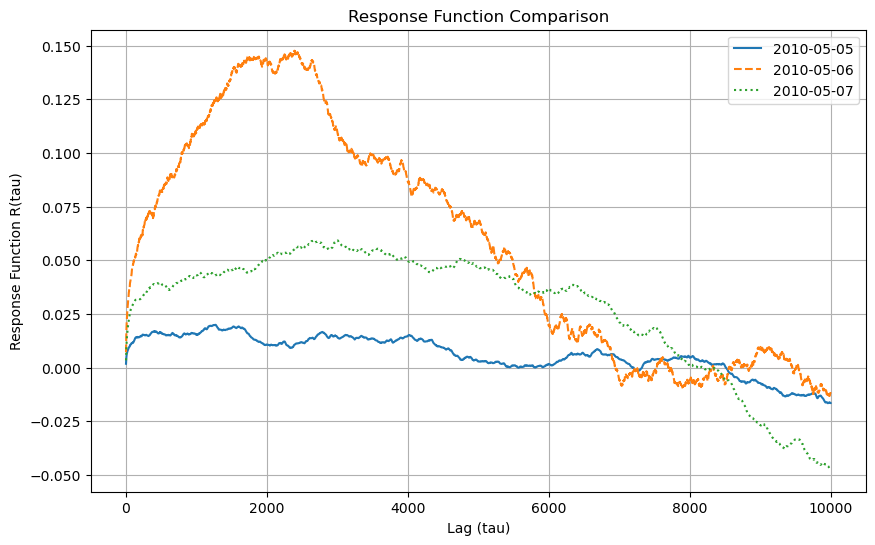

In [5]:
def filter_by_date(df: pl.DataFrame, target_date: str) -> pl.DataFrame:
    """
    Filters the Polars DataFrame by the given date string
    and returns a new DataFrame.
    """
    return df.filter(pl.col("date") == target_date)


# Filter data for specific dates
df_20100505 = filter_by_date(AAPL, "2010-05-05")
df_20100506 = filter_by_date(AAPL, "2010-05-06")
df_20100507 = filter_by_date(AAPL, "2010-05-07")

# Compute response functions
tau_max = 10000
response_20100505 = compute_response_function(df_20100505, tau_max)
response_20100506 = compute_response_function(df_20100506, tau_max)
response_20100507 = compute_response_function(df_20100507, tau_max)

# Plot comparison (matplotlib)
plt.figure(figsize=(10, 6))
plt.plot(range(1, tau_max + 1), response_20100505, label='2010-05-05')
plt.plot(range(1, tau_max + 1), response_20100506, label='2010-05-06', linestyle='--')
plt.plot(range(1, tau_max + 1), response_20100507, label='2010-05-07', linestyle=':')
plt.xlabel('Lag (tau)')
plt.ylabel('Response Function R(tau)')
plt.title('Response Function Comparison')
plt.legend()
plt.grid()
plt.show()

We observe much higher magnitude in response for 2010-05-06, this is because it is the day of the Flash Crash, were the US stock market experienced extreme volatility. The response keeps decreasing with increasing tau, likely due to dominance of sell trades and strong negative autocorrelations.

**Flash crash detection**

In [68]:
def detect_flash_crashes(
    df: pl.DataFrame, 
    tau_max: int, 
    threshold: float
) -> pl.DataFrame:
    """
    Detects days that have potential flash crashes by computing 
    the response function for each unique date and comparing 
    its maximum value to a threshold.

    Parameters:
    -----------
    df : pl.DataFrame
        The DataFrame containing the columns:
        ['date', 'bid-price', 'ask-price', 'trade-price', ...].
    tau_max : int
        Maximum lag for the response function.
    threshold : float
        Threshold above which we flag the day as a potential 
        flash crash.
    
    Returns:
    --------
    pl.DataFrame
        A DataFrame with columns ['date', 'max_response'] 
        for flagged days.
    """
    # Get unique dates in the dataset
    unique_dates = df.select(pl.col("date")).unique().to_series().to_list()

    # List to store (date, max_response) for flagged days
    flash_crash_days = []

    for d in unique_dates:
        # Filter DataFrame by this date
        daily_df = df.filter(pl.col("date") == d)

        # Compute response function
        response = compute_response_function(daily_df, tau_max)

        # If you prefer absolute values, use np.nanmax(np.abs(response)) 
        # instead of np.nanmax(response)
        max_resp = np.nanmax(response)

        # Check against threshold
        if max_resp > threshold:
            flash_crash_days.append((d, max_resp))

    # Convert flagged days into a Polars DataFrame
    flash_crash_df = pl.DataFrame(
        {
            "date": [x[0] for x in flash_crash_days],
            "max_response": [x[1] for x in flash_crash_days]
        }
    )
    return flash_crash_df

In [ ]:
tau_max = 10_000
threshold = 0.5 

# 3. Detect flash crashes
flash_crashes = detect_flash_crashes(AAPL, tau_max, threshold)

# 4. Print or save the resulting table of flagged days
print(flash_crashes)

**Example of use** 

In [100]:
SPY_polars = pl.read_parquet('data/SPY.P_events_short.parquet')


In [101]:
def to_timeseries(df: pl.DataFrame) -> pl.DataFrame:
    """
    Converts the existing `index` column (already a Polars datetime) into
    a standard "DATETIME" column, optionally rounding to the nearest second.
    """
    return (
        df
        .rename({"index": "DATETIME"})
        .with_columns(pl.col("DATETIME").dt.round("1s").alias("DATETIME"))
    )

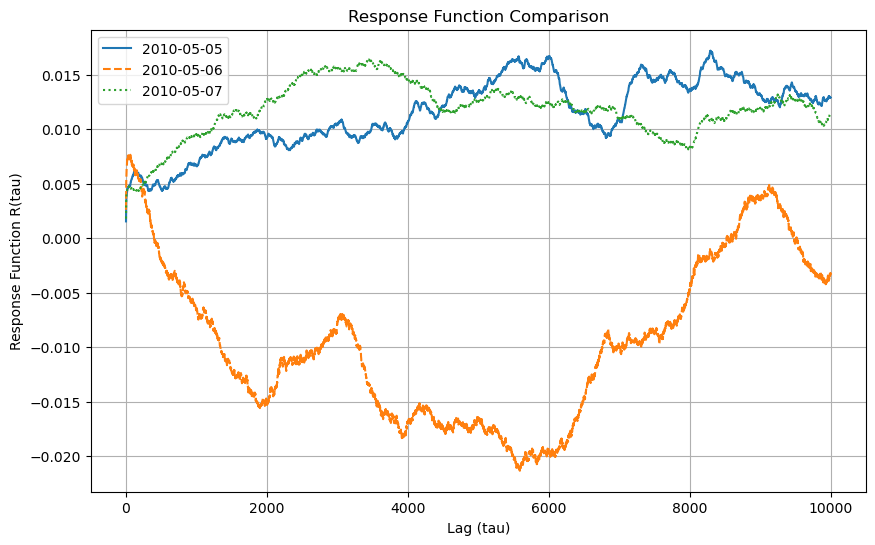

In [102]:
SPY_polars = to_timeseries(SPY_polars)

def filter_by_date(df: pl.DataFrame, target_date: str) -> pl.DataFrame:
    """
    Filters the Polars DataFrame by the given date string (e.g., "2010-05-05")
    and returns a new DataFrame.
    """
    return df.filter(
        pl.col("date") == pl.lit(target_date).cast(pl.Date)
    )


# Filter data for specific dates
df_20100505 = filter_by_date(SPY_polars, "2010-05-05")
df_20100506 = filter_by_date(SPY_polars, "2010-05-06")
df_20100507 = filter_by_date(SPY_polars, "2010-05-07")

# Compute response functions
tau_max = 10000
response_20100505 = compute_response_function(df_20100505, tau_max)
response_20100506 = compute_response_function(df_20100506, tau_max)
response_20100507 = compute_response_function(df_20100507, tau_max)

# Plot comparison (matplotlib)
plt.figure(figsize=(10, 6))
plt.plot(range(1, tau_max + 1), response_20100505, label='2010-05-05')
plt.plot(range(1, tau_max + 1), response_20100506, label='2010-05-06', linestyle='--')
plt.plot(range(1, tau_max + 1), response_20100507, label='2010-05-07', linestyle=':')
plt.xlabel('Lag (tau)')
plt.ylabel('Response Function R(tau)')
plt.title('Response Function Comparison')
plt.legend()
plt.grid()
plt.show()

## Computing response function per hour 

In [107]:
import datetime
import polars as pl
import numpy as np

def compute_hourly_response(
    df: pl.DataFrame,
    date_str: str,        # e.g. "2010-05-05"
    tau_max: int
) -> pl.DataFrame:
    """
    Groups the DataFrame by hour for a specific date and computes
    the response function for each hour using `compute_response_function`.

    Returns a Polars DataFrame with columns:
       - "hour" (integer 0..23)
       - "response" (the np.ndarray response returned by compute_response_function)
    """
    # 1) Filter the DataFrame by the given date.
    #    If your 'date' column is of type pl.Date, we must cast the string to a Date
    #    or convert the string into a Python datetime.date object for comparison.

    # Option A: cast the literal to pl.Date and compare
    df_date = df.filter(pl.col("date") == pl.lit(date_str).cast(pl.Date))

    # If that fails (or if 'date' is actually a string column), you can do:
    # df_date = df.filter(pl.col("date") == date_str)

    if df_date.is_empty():
        raise ValueError(f"No trades found for the date {date_str}.")

    # 2) Extract hour from your datetime column ("DATETIME" or "index").
    #    Adjust the column name to match your actual column name.
    df_date = df_date.with_columns([
        pl.col("DATETIME").dt.hour().alias("hour")
    ])

    # 3) Group by hour, then apply your per-group transformation
    #    We'll produce rows: hour => [response_array]
    hourly_response = (
        df_date
        .groupby("hour")
        .apply(lambda group_df: pl.DataFrame({
            "hour": [group_df["hour"][0]],
            "response": [compute_response_function(group_df, tau_max)]
        }))
    )

    return hourly_response


In [108]:
tau_max = 1400
hourly_response_20100505 = compute_hourly_response(df_20100505, '2010-05-05', tau_max)
hourly_response_20100506 = compute_hourly_response(df_20100506, '2010-05-06', tau_max)

AttributeError: 'DataFrame' object has no attribute 'groupby'

# For all the parquet files

In [2]:
import pandas as pd
import numpy as np
import polars as pl
import tarfile
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
import polars as pl
import numpy as np
from pathlib import Path

def already_processed(ticker: str, out_file: Path) -> bool:
    """
    Check if a given ticker already exists in the output_parquet.
    Returns True if the ticker is found, False otherwise.
    """
    if not out_file.exists():
        # If output file doesn't exist yet, obviously not processed
        return False
    
    # Read only the ticker column to save memory
    df_ticker = pl.read_parquet(str(out_file), columns=["ticker"]).unique()
    return ticker in df_ticker["ticker"].to_list()


def compute_response_function(df: pl.DataFrame, tau_max: int) -> np.ndarray:
    """
    Computes the response function R(tau) for all lags up to tau_max.
    Expects df to have columns: 'bid-price', 'ask-price', 'trade-price'.

    Args:
        df (pl.DataFrame): DataFrame with 'bid-price', 'ask-price', 'trade-price'.
        tau_max (int): Maximum lag for which to compute the response function.

    Returns:
        np.ndarray: Array of response values for each tau from 1 to tau_max.
    """
    # Compute mid-price
    df = df.with_columns(
        ((pl.col("bid-price") + pl.col("ask-price")) / 2).alias("mid-price")
    )

    # Compute the sign s = sign(trade-price - mid-price), fill trade-price nulls with 0
    df = df.with_columns(
        (pl.col("trade-price").fill_null(0) - pl.col("mid-price")).sign().alias("s")
    )

    # Convert to NumPy arrays
    m = df["mid-price"].to_numpy()
    s = df["s"].to_numpy()

    # Ensure tau_max does not exceed data length
    tau_max = min(tau_max, len(m) - 1)
    response = []

    for tau in range(1, tau_max + 1):
        # Only compute if we have enough data after shifting
        if len(m[tau:]) > 0:
            shifted_diff = m[tau:] - m[:-tau]  # m_{n+tau} - m_n
            resp = np.mean(s[:-tau] * shifted_diff)
            response.append(resp)
        else:
            response.append(np.nan)

    return np.array(response)


def compute_response_by_date_for_folder(
    folder_path: str,
    tau_max: int,
    output_parquet: str
):
    """
    For each *.parquet in folder_path:
      - If the ticker is already in output_parquet, skip it.
      - Otherwise, group by date, compute the response function, and append results to output_parquet.

    The output file will have columns: [ticker, date, tau, response].
    """
    folder = Path(folder_path)
    out_file = Path(output_parquet)

    # Iterate over all parquet files in the folder
    for file_path in folder.glob("*.parquet"):
        ticker = file_path.stem  # e.g., "AAPL.OQ_combined"

        # Check if we already have this ticker in the final parquet
        if already_processed(ticker, out_file):
            print(f"Skipping {ticker}, already processed.")
            continue

        print(f"Processing {ticker}...")

        # Read in the data
        df = pl.read_parquet(str(file_path))

        # Gather results in a Python list of dicts
        results = []

        # Get all unique dates
        unique_dates = df["date"].unique().to_list()

        for date_val in unique_dates:
            # Filter to just that date
            group_df = df.filter(pl.col("date") == date_val)
            if group_df.is_empty():
                continue

            # Compute the response function
            response_arr = compute_response_function(group_df, tau_max)

            # Collect each tau's response
            for tau_idx, resp_val in enumerate(response_arr, start=1):
                results.append({
                    "ticker": ticker,
                    "date": date_val,
                    "tau": tau_idx,
                    "response": resp_val,
                })

        # Skip writing if no results (shouldn't happen if the file had data)
        if not results:
            print(f"No valid response data for {ticker}.")
            continue

        # Convert to Polars DataFrame
        final_df = pl.DataFrame(results)

        # If out_file doesn't exist, just write it
        if not out_file.exists():
            final_df.write_parquet(str(out_file))
        else:
            # If it does exist, read it and append
            existing_df = pl.read_parquet(str(out_file))
            combined = pl.concat([existing_df, final_df], how="vertical")
            combined.write_parquet(str(out_file))

        print(f"Finished {ticker}, appended to {out_file}.")


In [8]:
compute_response_by_date_for_folder(
        folder_path="data",
        tau_max=1000,
        output_parquet="response_functions_all_stocks.parquet"
    )

Processing AAPL.OQ_combined...
Processing AMGN.OQ_combined...
Processing AXP.N_combined...
Processing BA.N_combined...
Processing CAT.N_combined...
Processing CSCO.OQ_combined...
Processing CVX.N_combined...
Processing DOW.N_combined...
Processing GS.N_combined...
Processing HD.N_combined...
Processing IBM.N_combined...
Processing INTC.OQ_combined...
Processing JNJ.N_combined...
Processing JPM.N_combined...
Processing KO.N_combined...
Processing MCD.N_combined...
Processing MMM.N_combined...
Processing MRK.N_combined...
Processing MSFT.OQ_combined...
Processing NKE.N_combined...
Processing PFE.N_combined...
Processing PG.N_combined...
Processing TRV.N_combined...
Processing UNH.N_combined...
Processing UTX.N_combined...
Processing V.N_combined...
Processing VZ.N_combined...
Processing WMT.N_combined...
Processing XOM.N_combined...
Done! Results written to response_functions_all_stocks.parquet


In [22]:
def determine_percentile_threshold(
    response_parquet: str, 
    tau_max: int, 
    percentile: float = 99.0
) -> float:
    """
    Determines the threshold based on a specified percentile of the max_response values.
    This implementation avoids using `groupby` by utilizing window functions.
    
    Parameters:
    -----------
    response_parquet : str
        Path to the Parquet file with columns [ticker, date, tau, response].
    tau_max : int
        The maximum lag to consider.
    percentile : float
        The percentile to use for thresholding (e.g., 99.0 for the 99th percentile).

    Returns:
    --------
    float
        The computed threshold value.
    """
    # 1. Read the response data
    try:
        df = pl.read_parquet(response_parquet)
        print(f"Successfully read {response_parquet}")
    except Exception as e:
        raise IOError(f"Failed to read {response_parquet}: {e}")

    # 4. Filter by tau_max
    df_filtered = df.filter(pl.col("tau") <= tau_max)

    # 5. Compute max_response per (ticker, date) using window functions
    df_with_max = df_filtered.with_columns(
        pl.col("response").max().over(["ticker", "date"]).alias("max_response")
    )

    # 6. Extract unique (ticker, date, max_response) combinations
    df_daily_max = df_with_max.select(["ticker", "date", "max_response"]).unique()
    print(f"Daily Max DataFrame shape: {df_daily_max.shape}")

    # 7. Calculate the desired percentile
    try:
        threshold = df_daily_max["max_response"].quantile(percentile / 100.0)
        print(f"Determined threshold at the {percentile}th percentile: {threshold}")
    except Exception as e:
        raise RuntimeError(f"Failed to compute quantile: {e}")

    return threshold


In [26]:
def detect_flash_crashes_from_response_file(
    response_parquet: str, 
    tau_max: int, 
    threshold: float, 
    output_parquet: str
):
    """
    Reads a Parquet file with precomputed response functions, detects potential flash-crash
    days by looking at the maximum response for each (ticker, date), and writes a filtered 
    Parquet of flagged days.

    This implementation avoids using `groupby` by utilizing window functions.

    Parameters
    ----------
    response_parquet : str
        Path to the Parquet file that has columns [ticker, date, tau, response].
    tau_max : int
        The maximum lag to consider; rows with tau > tau_max will be ignored.
    threshold : float
        The cut-off above which we label a day as having a potential flash crash.
    output_parquet : str
        Path to the Parquet file in which to store flash-crash detections. This file 
        will have columns [ticker, date, max_response].
    """

    try:
        df = pl.read_parquet(response_parquet)
        print(f"Successfully read {response_parquet}")
    except Exception as e:
        raise IOError(f"Failed to read {response_parquet}: {e}")

    # 4. Filter by tau_max
    df_filtered = df.filter(pl.col("tau") <= tau_max)

    # 5. Compute max_response per (ticker, date) using window functions
    df_with_max = df_filtered.with_columns(
        pl.col("response").max().over(["ticker", "date"]).alias("max_response")
    )
    # 6. Extract unique (ticker, date, max_response) combinations
    df_daily_max = df_with_max.select(["ticker", "date", "max_response"]).unique()
    # 7. Filter days where max_response exceeds the threshold
    df_flash_crash = df_daily_max.filter(pl.col("max_response") > threshold)

    # 8. Write the flagged days to the output Parquet file
    if df_flash_crash.is_empty():
        print("No potential flash-crash days found. Writing empty file.")
    else:
        print(f"Writing flash-crash detections to {output_parquet} ...")

    df_flash_crash.write_parquet(output_parquet)
    print("Flash-crash detection completed.")


In [32]:
test = pl.read_parquet("response_functions_all_stocks.parquet")
test.shape

(5754000, 4)

In [27]:
tau_max = 100  
percentile = 99.0  # Starting with the 99th percentile
threshold = determine_percentile_threshold("response_functions_all_stocks.parquet", tau_max)

Successfully read response_functions_all_stocks.parquet
Daily Max DataFrame shape: (5754, 3)
Determined threshold at the 99.0th percentile: 0.008211838832022249


In [28]:
detect_flash_crashes_from_response_file(
        response_parquet="response_functions_all_stocks.parquet", 
        tau_max=100,            # or any integer limit on tau
        threshold=threshold,         # or any threshold that suits your detection logic
        output_parquet="flash_crashes_detected.parquet"
    )

Successfully read response_functions_all_stocks.parquet
Writing flash-crash detections to flash_crashes_detected.parquet ...
Flash-crash detection completed.


In [31]:
test2 = pl.read_parquet("flash_crashes_detected.parquet")
test2

ticker,date,max_response
str,str,f64
"""AAPL.OQ_combined""","""2010-11-03""",0.011162
"""IBM.N_combined""","""2010-01-19""",NaN
"""AAPL.OQ_combined""","""2010-11-29""",0.012902
"""AAPL.OQ_combined""","""2010-06-08""",0.011305
"""GS.N_combined""","""2010-10-26""",NaN
…,…,…
"""WMT.N_combined""","""2010-12-15""",NaN
"""AAPL.OQ_combined""","""2010-12-07""",0.010424
"""JPM.N_combined""","""2010-01-19""",NaN


# Test Covariance matrix

In [20]:
import pandas as pd
import numpy as np
import polars as pl
import tarfile
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
AAPL = pl.read_parquet("data/AAPL.OQ_combined.parquet")
AMGN = pl.read_parquet("data/AMGN.OQ_combined.parquet")

In [36]:
def filter_by_date(df: pl.DataFrame, target_date: str) -> pl.DataFrame:
    """
    Filters the Polars DataFrame by the given date string
    and returns a new DataFrame.
    """
    return df.filter(pl.col("date") == target_date)

AAPL_flash_crash_day = filter_by_date(AAPL, "2010-05-06")
AMGN_flash_crash_day = filter_by_date(AMGN, "2010-05-06")

In [38]:
AAPL_flash_crash_day = AAPL_flash_crash_day.with_columns(
    pl.col('index').str.slice(11, 12).alias('truncated_index')  # Extract "HH:MM:SS.ssssss"
)
AMGN_flash_crash_day = AMGN_flash_crash_day.with_columns(
    pl.col('index').str.slice(11, 12).alias('truncated_index')
)

In [39]:
AAPL_flash_crash_day.head()

index,xltime,bid-price,bid-volume,ask-price,ask-volume,trade-price,trade-volume,date,truncated_index
str,f64,f64,i64,f64,i64,f64,i64,str,str
"""2010-05-06T09:30:00.048000""",40304.562501,253.53,6,254.17,8,null,null,"""2010-05-06""","""09:30:00.048"""
"""2010-05-06T09:30:00.102000""",40304.562501,253.53,6,254.15,5,null,null,"""2010-05-06""","""09:30:00.102"""
"""2010-05-06T09:30:00.134000""",40304.562502,253.53,6,253.89,1,null,null,"""2010-05-06""","""09:30:00.134"""
"""2010-05-06T09:30:00.140000""",40304.562502,253.53,7,253.89,1,null,null,"""2010-05-06""","""09:30:00.140"""
"""2010-05-06T09:30:00.226000""",40304.562503,253.53,7,254.15,5,null,null,"""2010-05-06""","""09:30:00.226"""


In [24]:
# Unique indices in each dataframe
#AAPL_indices = set(AAPL_flash_crash_day['truncated_index'])
#AMGN_indices = set(AMGN_flash_crash_day['truncated_index'])

# Number of shared and unique indices
#shared_indices = len(AAPL_indices.intersection(AMGN_indices))
#unique_AAPL_indices = len(AAPL_indices - AMGN_indices)
#unique_AMGN_indices = len(AMGN_indices - AAPL_indices)

#print(f"Number of shared indices: {shared_indices}")
#print(f"Number of unique indices in AAPL: {unique_AAPL_indices}")
#print(f"Number of unique indices in AMGN: {unique_AMGN_indices}")


In [25]:
AAPL_flash_crash_day = AAPL_flash_crash_day.with_columns(((AAPL_flash_crash_day['bid-price'] + AAPL_flash_crash_day['ask-price']) / 2).alias('mid_price'))
AMGN_flash_crash_day = AMGN_flash_crash_day.with_columns(((AMGN_flash_crash_day['bid-price'] + AMGN_flash_crash_day['ask-price']) / 2).alias('mid_price'))

AAPL_flash_crash_day = AAPL_flash_crash_day.with_columns(AAPL_flash_crash_day['mid_price'].pct_change().alias('mid_price_return'))
AMGN_flash_crash_day = AMGN_flash_crash_day.with_columns(AMGN_flash_crash_day['mid_price'].pct_change().alias('mid_price_return'))

# Remove rows where returns are zero or NaN
AAPL_flash_crash_day = AAPL_flash_crash_day.filter(AAPL_flash_crash_day['mid_price_return'] != 0).drop_nulls()
AMGN_flash_crash_day = AMGN_flash_crash_day.filter(AMGN_flash_crash_day['mid_price_return'] != 0).drop_nulls()

# 3. Join the dataframes with full join and sort
result_pl_df = AAPL_flash_crash_day.join(AMGN_flash_crash_day, on='truncated_index', how='full').sort('truncated_index')

In [26]:
# Count rows with null values from each dataframe
#null_in_asset1 = result_pl_df.select(pl.col('mid_price').is_null().sum()).to_numpy()[0][0]
#null_in_asset2 = result_pl_df.select(pl.col('mid_price_right').is_null().sum()).to_numpy()[0][0]

#print(f"Rows with missing data from asset1: {null_in_asset1}")
#print(f"Rows with missing data from asset2: {null_in_asset2}")


In [27]:
# Forward-fill directly on the existing columns
result_pl_df_filled = result_pl_df.with_columns([
    pl.col('mid_price').fill_null(strategy='forward'),
    pl.col('mid_price_right').fill_null(strategy='forward')
])


In [28]:
#null_in_asset1 = result_pl_df_filled.select(pl.col('mid_price').is_null().sum()).to_numpy()[0][0]
#null_in_asset2 = result_pl_df_filled.select(pl.col('mid_price_right').is_null().sum()).to_numpy()[0][0]

#print(f"Rows with missing data from asset1 after forward-fill: {null_in_asset1}")
#print(f"Rows with missing data from asset2 after forward-fill: {null_in_asset2}")


**Cut in 3 dataframes**

In [29]:
import polars as pl
from datetime import datetime, timedelta
from typing import Tuple

def split_dataframe_by_quarter(df: pl.DataFrame, start_time_str: str) -> Tuple[pl.DataFrame, pl.DataFrame, pl.DataFrame]:
    clean_df = df.filter(
        (pl.col('mid_price_return').is_not_null()) & 
        (pl.col('mid_price_return_right').is_not_null())
    )
    
    arbitrary_date = "2000-01-01"
    start_datetime_str = f"{arbitrary_date} {start_time_str}:00"
    start_datetime = datetime.strptime(start_datetime_str, "%Y-%m-%d %H:%M:%S")
    
    quarter_duration = timedelta(minutes=15)
    end_datetime = start_datetime + quarter_duration
    
    start_quarter = start_datetime.strftime("%H:%M:%S")
    end_quarter = end_datetime.strftime("%H:%M:%S")
    
    df_before_quarter = clean_df.filter(pl.col("truncated_index") < start_quarter)
    df_during_quarter = clean_df.filter(
        (pl.col("truncated_index") >= start_quarter) & 
        (pl.col("truncated_index") <= end_quarter)
    )
    df_after_quarter = clean_df.filter(pl.col("truncated_index") > end_quarter)
    
    return df_before_quarter, df_during_quarter, df_after_quarter

In [32]:
df_before, df_during, df_after = split_dataframe_by_quarter(result_pl_df_filled, start_time)

Rows before the quarter: 59437
Rows during the quarter: 8131
Rows after the quarter: 17758


In [17]:
from intervaltree import Interval, IntervalTree

def hayashi_yoshida_covariance(dataframe, default_columns=("mid_price_return", "mid_price_return_right")):
    """
    Calculate the Hayashi-Yoshida covariance estimator for two numeric columns in a dataframe.

    Parameters:
        dataframe (pl.DataFrame): The input dataframe.
        default_columns (tuple): A tuple specifying default column names for the calculation.

    Returns:
        dict: A dictionary containing the Hayashi-Yoshida covariance, variances, and correlation.
    """
    if all(col in dataframe.columns for col in default_columns):
        col_x, col_y = default_columns
    else:
        raise ValueError(
            f"The dataframe must contain the specified columns: {default_columns}"
        )

    # Convert Polars DataFrame to Pandas for interval handling
    df = dataframe.to_pandas()

    # Extract necessary columns and drop NaNs
    df_x = df[["truncated_index", col_x]].dropna().sort_values(by="truncated_index").drop_duplicates(subset="truncated_index")
    df_y = df[["truncated_index_right", col_y]].dropna().sort_values(by="truncated_index_right").drop_duplicates(subset="truncated_index_right")

    # Parse truncated_index into proper datetime with millisecond precision
    df_x["truncated_index"] = pd.to_datetime(df_x["truncated_index"], format="%H:%M:%S.%f")
    df_y["truncated_index_right"] = pd.to_datetime(df_y["truncated_index_right"], format="%H:%M:%S.%f")

    # Create intervals for both series
    intervals_x = pd.IntervalIndex.from_arrays(
        df_x["truncated_index"][:-1], df_x["truncated_index"][1:], closed="right"
    )
    intervals_y = pd.IntervalIndex.from_arrays(
        df_y["truncated_index_right"][:-1], df_y["truncated_index_right"][1:], closed="right"
    )

    # Build an interval tree for Y
    tree_y = IntervalTree(
        Interval(begin.value, end.value, idx)
        for idx, (begin, end) in enumerate(zip(df_y["truncated_index_right"][:-1], df_y["truncated_index_right"][1:]))
    )

    # Calculate covariance
    covariance = 0
    for i, interval_x in enumerate(intervals_x):
        overlaps = tree_y.overlap(interval_x.left.value, interval_x.right.value)  # Use overlap instead of search
        for overlap in overlaps:
            j = overlap.data  # Index in df_y
            covariance += df_x[col_x].iloc[i] * df_y[col_y].iloc[j]

    # Calculate variances
    variance_x = np.sum(df_x[col_x] ** 2)
    variance_y = np.sum(df_y[col_y] ** 2)

    # Calculate correlation
    correlation = covariance / np.sqrt(variance_x * variance_y)

    return {
        "hayashi_yoshida_covariance": covariance,
        "variance_x": variance_x,
        "variance_y": variance_y,
        "correlation": correlation,
    }


In [18]:
# Call the function on your dataframe
result = hayashi_yoshida_covariance(df_before_quarter)
result_2 = hayashi_yoshida_covariance(df_during_quarter)
result_3 = hayashi_yoshida_covariance(df_after_quarter)
# Print results
print(f"Hayashi-Yoshida Covariance: {result['hayashi_yoshida_covariance']}")
print(f"Variance of X: {result['variance_x']}")
print(f"Variance of Y: {result['variance_y']}")
print(f"Correlation: {result['correlation']}")
print()
# Print results
print(f"Hayashi-Yoshida Covariance: {result_2['hayashi_yoshida_covariance']}")
print(f"Variance of X: {result_2['variance_x']}")
print(f"Variance of Y: {result_2['variance_y']}")
print(f"Correlation: {result_2['correlation']}")
print()
# Print results
print(f"Columns used: {result_3['columns']}")
print(f"Hayashi-Yoshida Covariance: {result_3['hayashi_yoshida_covariance']}")
print(f"Variance of X: {result_3['variance_x']}")
print(f"Variance of Y: {result_3['variance_y']}")
print(f"Correlation: {result_3['correlation']}")


Columns used: ('mid_price_return', 'mid_price_return_right')
Hayashi-Yoshida Covariance: -1.4890817019416107e-05
Variance of X: 0.0008115400465471208
Variance of Y: 5.604403826875911e-06
Correlation: -0.22079988290381533

Columns used: ('mid_price_return', 'mid_price_return_right')
Hayashi-Yoshida Covariance: -0.00012031753513600134
Variance of X: 0.06770429394599964
Variance of Y: 2.6253316839041454e-05
Correlation: -0.09024615957915567

Columns used: ('mid_price_return', 'mid_price_return_right')
Hayashi-Yoshida Covariance: -1.5798385847689032e-05
Variance of X: 0.0010735912110503942
Variance of Y: 1.1241841328063137e-05
Correlation: -0.14380517573658844


## ALL the files covariance matrix

In [44]:
def process_pair(asset1_file, asset2_file, date, start_time):
    """
    Process two parquet files to compute the Hayashi-Yoshida covariance, variances, and correlations.

    Parameters:
        asset1_file (str): Path to the first asset's parquet file.
        asset2_file (str): Path to the second asset's parquet file.
        date (str): The date to filter on (e.g., "2010-05-06").
        start_time (str): The start time of the quarter (e.g., "09:30").

    Returns:
        dict: A dictionary containing the results for each period (before, during, after).
    """

    # Load the parquet files
    asset1 = pl.read_parquet(asset1_file)
    asset2 = pl.read_parquet(asset2_file)

    # Filter by date
    asset1 = filter_by_date(asset1, date)
    asset2 = filter_by_date(asset2, date)

    # Add truncated index
    asset1 = asset1.with_columns(pl.col('index').str.slice(11, 12).alias('truncated_index'))
    asset2 = asset2.with_columns(pl.col('index').str.slice(11, 12).alias('truncated_index'))

    # Compute mid-price and mid-price returns
    asset1 = asset1.with_columns(((asset1['bid-price'] + asset1['ask-price']) / 2).alias('mid_price'))
    asset1 = asset1.with_columns(asset1['mid_price'].pct_change().alias('mid_price_return'))
    asset1 = asset1.filter(asset1['mid_price_return'] != 0).drop_nulls()

    asset2 = asset2.with_columns(((asset2['bid-price'] + asset2['ask-price']) / 2).alias('mid_price'))
    asset2 = asset2.with_columns(asset2['mid_price'].pct_change().alias('mid_price_return'))
    asset2 = asset2.filter(asset2['mid_price_return'] != 0).drop_nulls()

        

    # Join the dataframes
    result_df = asset1.join(asset2, on='truncated_index', how='full').sort('truncated_index')

    # Forward fill
    result_df = result_df.with_columns([
        pl.col('mid_price').fill_null(strategy='forward'),
        pl.col('mid_price_right').fill_null(strategy='forward')
    ])

    result_pl_df_filled = result_pl_df.with_columns([
        pl.col('mid_price').fill_null(strategy='forward'),
        pl.col('mid_price_right').fill_null(strategy='forward')
    ])

    # Split the dataframe into periods
    df_before, df_during, df_after = split_dataframe_by_quarter(result_df, start_time)

    # Compute covariance and variances for each period
    results = {
        "before": hayashi_yoshida_covariance(df_before),
        "during": hayashi_yoshida_covariance(df_during),
        "after": hayashi_yoshida_covariance(df_after),
    }
    
    return results


In [45]:
AAPL = pl.read_parquet("data/AAPL.OQ_combined.parquet")
AMGN = pl.read_parquet("data/AMGN.OQ_combined.parquet")


results = process_pair("data/AAPL.OQ_combined.parquet","data/AMGN.OQ_combined.parquet","2010-05-06","14:45")

In [47]:
# Access and print the results for the 'before' group
print("Results for the 'before' group:")
for key, value in results["before"].items():
    print(f"{key}: {value}")
for key, value in results["during"].items():
    print(f"{key}: {value}")
for key, value in results["after"].items():
    print(f"{key}: {value}")

Results for the 'before' group:
columns: ('mid_price_return', 'mid_price_return_right')
hayashi_yoshida_covariance: 4.6598161306899626e-07
variance_x: 3.0557134919094433e-06
variance_y: 5.604403826875911e-06
correlation: 0.1126024277275251
columns: ('mid_price_return', 'mid_price_return_right')
hayashi_yoshida_covariance: -1.796399056251842e-06
variance_x: 0.00019806774824034315
variance_y: 2.6253316839041454e-05
correlation: -0.024911727585088677
columns: ('mid_price_return', 'mid_price_return_right')
hayashi_yoshida_covariance: 3.3933135538271396e-08
variance_x: 8.264664089038107e-06
variance_y: 1.1241841328063137e-05
correlation: 0.003520405273266799


In [ ]:
Columns used: ('mid_price_return', 'mid_price_return_right')
Hayashi-Yoshida Covariance: -1.4890817019416107e-05
Variance of X: 0.0008115400465471208
Variance of Y: 5.604403826875911e-06
Correlation: -0.22079988290381533

Columns used: ('mid_price_return', 'mid_price_return_right')
Hayashi-Yoshida Covariance: -0.00012031753513600134
Variance of X: 0.06770429394599964
Variance of Y: 2.6253316839041454e-05
Correlation: -0.09024615957915567

Columns used: ('mid_price_return', 'mid_price_return_right')
Hayashi-Yoshida Covariance: -1.5798385847689032e-05
Variance of X: 0.0010735912110503942
Variance of Y: 1.1241841328063137e-05
Correlation: -0.14380517573658844